In [1]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from load_dataset import HydraNetDataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import torch.optim as optim
from torch.utils.data import DataLoader , Dataset
from tqdm import tqdm
import os


In [2]:
# Path for the database location
cityscapes_dir = "/home/student/self_driving_car/dataset/cityscapes"
nyu_depth_v2_dir = "/home/student/self_driving_car/dataset/nyu_depth_v2"

# Loading the cityscapes paths of images
cityscapes_train =HydraNetDataLoader(cityscapes_dir, splits="train" , dataset_type="cityscapes" )
cityscapes_test = HydraNetDataLoader(cityscapes_dir, splits="test" , dataset_type="cityscapes" )
cityscapes_val = HydraNetDataLoader(cityscapes_dir, splits="val" , dataset_type="cityscapes" )

# Loading the NYU Depth V2 paths of images
nyu_depth_v2_train = HydraNetDataLoader(nyu_depth_v2_dir, splits= "nyu2_train"  , dataset_type="nyu_depth_v2" , splitfor="train")
nyu_depth_v2_test = HydraNetDataLoader(nyu_depth_v2_dir, splits="nyu2_test" , dataset_type="nyu_depth_v2" ,splitfor="test")
nyu_depth_v2_val = HydraNetDataLoader(nyu_depth_v2_dir, splits= "nyu2_val"  , dataset_type="nyu_depth_v2" , splitfor="val")


print("cityscapes train ", len(cityscapes_train))
print("cityscapes test ", len(cityscapes_test))
print("cityscapes val ", len(cityscapes_val))

print("nyu depth v2 train",len(nyu_depth_v2_train))
print("nyu depth v2 test",len(nyu_depth_v2_test))
print("nyu depth v2 val",len(nyu_depth_v2_val))


cityscapes train  2975
cityscapes test  1525
cityscapes val  500
nyu depth v2 train 46591
nyu depth v2 test 654
nyu depth v2 val 4097


In [3]:
# train datset
cti = cityscapes_train.image_paths  # [:100] # train image paths in list
cts = cityscapes_train.image_color_seg # [:100]  # train segmentation image paths in list
# ctj = cityscapes_train.image_ann
nti = nyu_depth_v2_train.image_paths # [:100] # train image paths in list
ntd = nyu_depth_v2_train.image_depths #[:100]   # train depth of image paths in list

# test dataset
ctei = cityscapes_test.image_paths #[:100] # test image paths in list
ctes = cityscapes_test.image_color_seg #[:100] # test segmentation image paths in list
# ctej = cityscapes_test.image_ann 
ntei = nyu_depth_v2_test.image_paths #[:100]  # test image paths in list
nted = nyu_depth_v2_test.image_depths #[:100]  # test depth of image paths in list

# val dataset
cvi = cityscapes_val.image_paths #[:100] # train image paths in list
cvs = cityscapes_val.image_color_seg #[:100]  # train segmentation image paths in list
# ctj = cityscapes_train.image_ann
nvi = nyu_depth_v2_val.image_paths #[:100] # train image paths in list
nvd = nyu_depth_v2_val.image_depths #[:100]   # train depth of image paths in list

print(len(cti))
print(len(cts))
print(len(nti))
print(len(ntd))
print(len(cvi))
print(len(cvs))
print(len(nvi))
print(len(nvd))


2975
2975
46591
46591
500
500
4097
4097


In [4]:
cmap = {
            0: (0, 0, 0), 1: (0, 0, 0), 2: (0, 0, 0), 3: (0, 0, 0), 4: (0, 0, 0), 5: (111, 74,  0) , 6: ( 81,  0, 81), 7: (128, 64, 128),
            8: (244, 35, 232), 9: (250,170,160) , 10: (230,150,140), 11: (70, 70, 70), 12: (102, 102, 156), 13: (190, 153, 153),
            14:(180,165,180), 15: (150,100,100), 16: (150,120, 90), 17: (153, 153, 153), 18: (153,153,153), 19: (250, 170, 30),
            20: (220, 220, 0), 21: (107, 142, 35), 22: (152, 251, 152), 23: ( 70,130,180) , 24: (220, 20, 60),
            25: (255, 0, 0), 26: (0, 0, 142), 27: (0, 0, 70), 28: (0, 60, 100), 29: (0,  0, 90), 30: (0, 0,110), 31: (0, 80, 100),
            32: (0, 0, 230), 33: (119, 11, 32),  34: (0, 0, 142) , 35: (  0,  0,142)
        }
label_to_index = {'unlabeled': 0, 'ego vehicle': 1, 'rectification border': 2, 'out of roi': 3, 'static': 4,
                      'dynamic': 5, 'ground': 6, 'road': 7, 'sidewalk': 8, 'parking': 9, 'rail track': 10,
                      'building': 11, 'wall': 12, 'fence': 13, 'guard rail': 14, 'bridge': 15, 'tunnel': 16,
                      'pole': 17, 'polegroup': 18, 'traffic light': 19, 'traffic sign': 20, 'vegetation': 21,
                      'terrain': 22, 'sky': 23, 'person': 24, 'rider': 25, 'car': 26, 'truck': 27, 'bus': 28,
                      'caravan': 29, 'trailer': 30, 'train': 31, 'motorcycle': 32, 'bicycle': 33, 'cargroup': 34,'license plate': 35}
print(len(cmap))

36


In [5]:
from networks.encoder import MobileNetv2
encoder = MobileNetv2()

encoder.load_state_dict(torch.load("/home/student/self_car/mobilenetv2-e6e8dd43.pth"))
print(encoder)

MobileNetv2(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layer2): Sequential(
    (0): InvertedResidualBlock(
      (output): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (2): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, af

In [6]:
from networks.decoder import MTLWRefineNet
num_classes = (36, 1)
decoder = MTLWRefineNet(encoder._out_c, num_classes)
print(decoder)

MTLWRefineNet(
  (stem_convs): ModuleList(
    (0): Conv2d(320, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(160, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (4): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): Conv2d(24, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (crp_blocks): ModuleList(
    (0-2): 3 x Sequential(
      (0): CRPBlock(
        (1_outvar_dimred): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2_outvar_dimred): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3_outvar_dimred): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4_outvar_dimred): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (maxpool): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ce

In [7]:
device = torch.device("cuda")
encoder = encoder.to(device)
decoder = decoder.to(device)
lr_encoder = 1e-2
lr_decoder = 1e-3
momentum_encoder = 0.9
momentum_decoder = 0.9
weight_decay_encoder = 1e-5
weight_decay_decoder = 1e-5

bat_siz_city = 5
bat_siz_nyu = 16

from networks.utils import InvHuberLoss

ignore_index = 255
ignore_depth = 0

crit_segm = nn.CrossEntropyLoss(ignore_index=ignore_index).cuda()
crit_depth = InvHuberLoss(ignore_index=ignore_depth).cuda()


In [8]:
optims = [torch.optim.SGD(encoder.parameters(), lr=lr_encoder, momentum=momentum_encoder, weight_decay=weight_decay_encoder),
         torch.optim.SGD(decoder.parameters(), lr=lr_decoder, momentum=momentum_decoder, weight_decay=weight_decay_decoder)]


In [9]:
n_epochs = 50

In [10]:
from networks.model_helpers import Saver, load_state_dict
import operator 
import json
import logging

init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./"
ckpt_path = "./checkpoint.pth.tar"

saver = Saver(
    args=locals(),
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

In [11]:
hydranet = nn.DataParallel(nn.Sequential(encoder, decoder)).cuda() # Use .cpu() if you prefer a slow death

print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

if start_epoch is None:
    start_epoch = 0
print(start_epoch)

Model has 3060837 parameters
0


In [12]:
opt_scheds = []
for opt in optims:
    opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(opt, np.arange(start_epoch + 1, n_epochs, 100), gamma=0.1))


In [13]:
import torch
import numpy as np
from PIL import Image
from torchvision.transforms import transforms

class CityscapesDataset():
    def __init__(self, image_paths, seg_path, data_type, cmap, transform=None, depth_scale=5000.0):
        self.image_paths = image_paths
        self.seg_path = seg_path
        self.transform = transform
        self.data_type = data_type
        self.cmap = cmap
        self.depth_scale = depth_scale

    def convert_to_single_channel(self, targets):
        """
        Convert segmentation masks to a single-channel tensor using class label numbers.
        """
        height, width = targets.size[1], targets.size[0]
        output = torch.zeros((height, width))
        for h in range(height):
            for w in range(width):
                pixel = tuple(targets.getpixel((w, h)))
                # Find the class label number corresponding to the pixel color
                for label, color in self.cmap.items():
                    if pixel == color:
                        output[h, w] = label
                        break
        return output
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.seg_path[idx]

        # Load image and target
        image = np.array(Image.open(image_path).convert("RGB"))
        

        if self.data_type == "city":
            target = Image.open(mask_path).convert("RGB")
            # Convert image to tensor and apply transformations
            image = transforms.ToTensor()(image)
            image = self.transform(image)
            # Resize and convert target to single-channel tensor
            target = transforms.Resize((180, 320))(target)
            target = self.convert_to_single_channel(target).unsqueeze(0)

            return image, target
        
        elif self.data_type == "nyu":
            # Convert image to float and scale depth
            target = Image.open(mask_path)
            image = np.array(Image.open(image_path).convert("RGB"))
            image = self.transform(image)
            image  = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)
            target = transforms.Resize((120, 160))(target)
            target = np.array(target, dtype=np.float32)  / self.depth_scale
            target = target.astype(np.float32) / target.max()
            target = transforms.ToTensor()(target)
# 4, 180, 320, 3
            return image, target

In [14]:
from torchvision.transforms import RandomApply, RandomRotation, RandomAffine, ColorJitter
from torchvision.transforms import Resize

transform_seg_train = transforms.Compose([
     transforms.ToPILImage(),RandomApply([transforms.RandomHorizontalFlip(p=0.5)], p=0.5),  
        RandomApply([RandomRotation(degrees=(-20, 20))], p=0.5),
        RandomApply([RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.5),
        # transforms.RandomCrop((1000,2000)),
        Resize((720,1280)),
    transforms.ToTensor() ,
])

transform_seg_val = transforms.Compose([
 transforms.ToPILImage(),
    transforms.ToTensor() ,
])

transform_depth_train = transforms.Compose([
    transforms.ToPILImage(),RandomApply([transforms.RandomHorizontalFlip(p=0.5)], p=0.5),  
        RandomApply([RandomRotation(degrees=(-20, 20))], p=0.5),
        RandomApply([RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.5),
        # transforms.RandomCrop((400, 600)),
        # Resize((400,600)),
    transforms.ToTensor(), 
])

transform_depth_val = transforms.Compose([
 transforms.ToPILImage(),
    transforms.ToTensor() ,
])

img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])


# Create train and val datasets
train_city_dataset = CityscapesDataset(image_paths=cti, seg_path=cts, data_type ="city",cmap = cmap , transform=transform_seg_train)
val_city_dataset = CityscapesDataset(image_paths=cvi, seg_path=cvs,data_type ="city",cmap =cmap , transform=transform_seg_val)
train_nyu_dataset = CityscapesDataset(image_paths=nti, seg_path=ntd, data_type ="nyu",cmap = cmap, depth_scale = depth_scale, transform=transform_depth_train)
val_nyu_dataset = CityscapesDataset(image_paths=nvi, seg_path=nvd,data_type ="nyu",cmap =cmap, depth_scale = depth_scale ,transform=transform_depth_val)
#annotation_paths=ctj

# Define data loaders
train_city_loader = DataLoader(train_city_dataset, batch_size= bat_siz_city, shuffle=True, pin_memory=True,drop_last=False,)
val_city_loader = DataLoader(val_city_dataset, batch_size= bat_siz_city, shuffle=True, pin_memory=True,drop_last=False,)
train_nyu_loader = DataLoader(train_nyu_dataset, batch_size= bat_siz_nyu, shuffle=True, pin_memory=True,drop_last=False,)
val_nyu_loader = DataLoader(val_nyu_dataset, batch_size= 4 , shuffle=True, pin_memory=True,drop_last=False,)

(3, 720, 1280)
(1, 180, 320)
[[[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0. 11. ... 11.  0.  0.]
  ...
  [ 0.  0.  6. ...  6.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]]
[ 0.  5.  6.  8. 11. 20. 21. 23. 24. 25. 26. 33.]


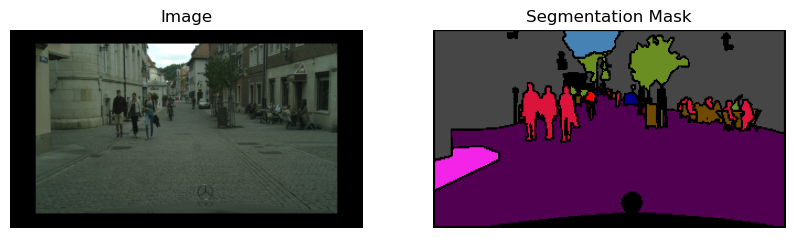

In [15]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Assuming train_city_loader contains the data
batch = next(iter(train_city_loader))
images, masks = batch
images = images.numpy()
masks = masks.numpy()
image = images[2]
mask = masks[2]

print(image.shape)
print(mask.shape)
print(mask)
print(np.unique(mask))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')

cmap_rgb = {k: tuple(v) for k, v in cmap.items()}
custom_cmap = mcolors.ListedColormap([cmap_rgb[value] for value in sorted(cmap.keys())])

# Convert the mask to RGB format (assuming it's in label format)
mask_rgb = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
for k, v in cmap_rgb.items():
    mask_rgb[np.where(mask[0] == k)] = v
    

plt.subplot(1, 2, 2)
plt.title('Segmentation Mask')
plt.imshow(mask_rgb)  
plt.axis('off')


plt.show()

(3, 1024, 2048)
(1, 180, 320)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[ 0.  7.  8. 11. 12. 17. 19. 20. 21. 23. 24. 26. 32. 33.]


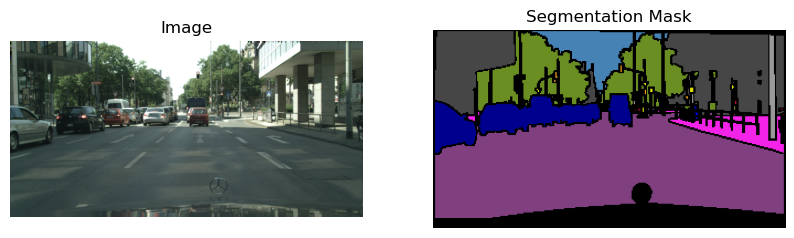

In [16]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Assuming train_city_loader contains the data
batch = next(iter(val_city_loader))
images, masks = batch
images = images.numpy()
masks = masks.numpy()
image = images[2]
mask = masks[2]

print(image.shape)
print(mask.shape)
print(mask)
print(np.unique(mask))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')

cmap_rgb = {k: tuple(v) for k, v in cmap.items()}
custom_cmap = mcolors.ListedColormap([cmap_rgb[value] for value in sorted(cmap.keys())])

# Convert the mask to RGB format (assuming it's in label format)
mask_rgb = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
for k, v in cmap_rgb.items():
    mask_rgb[np.where(mask[0] == k)] = v
    

plt.subplot(1, 2, 2)
plt.title('Segmentation Mask')
plt.imshow(mask_rgb)  
plt.axis('off')


plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 120, 160)


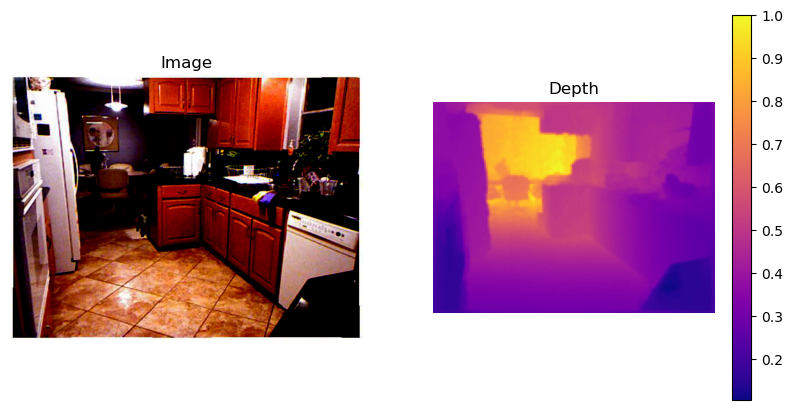

(3, 480, 640)
(120, 160)


In [17]:
import numpy as np
import matplotlib.pyplot as plt

batch = next(iter(train_nyu_loader))
images, masks = batch
images = images.numpy()
masks = masks.numpy()
image = images[0]
mask = masks[0]

print(mask.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Depth')

# Extract the depth map directly
depth_map = mask[0]  # Extracting the depth map directly without indexing the channels

# Normalize the depth values to [0, 1] range
# depth_map = depth_map.astype(np.float32) / depth_map.max()

plt.imshow(depth_map, cmap='plasma')
plt.colorbar()  # Add colorbar to show colormap scale
plt.axis('off')
plt.show()

print(image.shape)
print(depth_map.shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 120, 160)


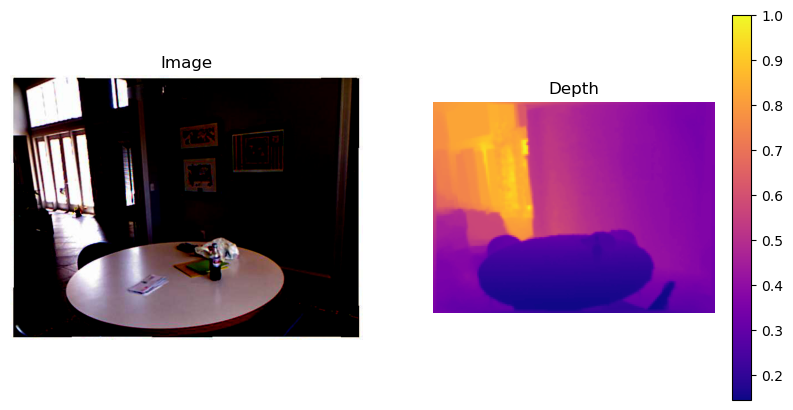

(120, 160)


In [18]:
import numpy as np
import matplotlib.pyplot as plt

batch = next(iter(val_nyu_loader))
images, masks = batch
images = images.numpy()
masks = masks.numpy()
image = images[0]
mask = masks[0]

print(mask.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Depth')

# Extract the depth map directly
depth_map = mask[0]  # Extracting the depth map directly without indexing the channels

# Normalize the depth values to [0, 1] range
# depth_map = depth_map.astype(np.float32) / depth_map.max()

plt.imshow(depth_map, cmap='plasma')
plt.colorbar()  # Add colorbar to show colormap scale
plt.axis('off')
plt.show()

print(depth_map.shape)


In [19]:
from networks.utils import AverageMeter
from tqdm import tqdm

In [20]:
def train_seg(model, opts, crits, dataloader, loss_coeffs, grad_norm=0.0):
    model.train()

    device = torch.device("cuda")
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        image , targets = sample
        
        #FORWARD
        outputs , _ = model(image)
        outputs = [outputs.to(device)]
        targets = [targets.to(device)]
        # print(outputs[0].shape)
        # print(_.shape)

        for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
            #TODO: Increment the Loss
            outs = F.interpolate(
                    out, size= target.size()[2:], mode="bilinear", align_corners=False
                ).squeeze(dim=1).to(device)

            outs = outs.type(torch.float)
            target = target.type(torch.long)
            crit_loss = crit(outs, target.squeeze(dim=1)).to(device)
            loss += loss_coeff * crit_loss 
            

        # BACKWARD
        for opt in opts:
            opt.zero_grad()
        loss.backward()

        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        #TODO: Run one step
        for opt in opts:
            opt.step()

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )



In [21]:
def validate_seg(model, metrics, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            # Get the Data
            image , targets = sample
            
            targets = [targets.squeeze(dim=1).to(device)]

            #input, targets = get_input_and_targets(sample=sample, dataloader=dataloader, device=device)
            
            # Forward
            outputs , _ = model(image)
            outputs = [outputs.to(device)]

            # Backward
            for out, target, metric in zip(outputs, targets , metrics):
                # print(out.shape)
                outs = F.interpolate(
                    out, size= target.size()[1:], mode="bilinear", align_corners=False
                ).squeeze(dim=1).to(device)
                target = target.type(torch.long)
                # print(outs.shape)
                # print(target.shape)
                metric.update(outs ,target)
                
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals


In [22]:
def train_depth(model, opts, crits, dataloader, loss_coeffs, grad_norm=0.0):
    model.train()

    device = torch.device("cuda")
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        image , targets = sample
        
        #FORWARD
        _ , outputs = model(image)
        outputs = [outputs.to(device)]
        targets = [targets.to(device)]

        
        for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
            #TODO: Increment the Loss

            outs = F.interpolate(
                    out, size= target.size()[2:], mode="bilinear", align_corners=False
                ).to(device)
            
            crit_loss = crit(outs, target.squeeze(dim=1)).to(device)
            loss += loss_coeff * crit_loss 
            

        # BACKWARD
        for opt in opts:
            opt.zero_grad()
        loss.backward()

        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        #TODO: Run one step
        for opt in opts:
            opt.step()

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )



In [23]:
def validate_depth(model, metrics, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            # Get the Data
            image , targets = sample
            
            targets = [targets.squeeze(dim=1).to(device)]
            
            # Forward
            _ , outputs = model(image)
            outputs = [outputs.to(device)]

            # Backward
            for out, target, metric in zip(outputs, targets , metrics):

                outs = F.interpolate(
                    out, size= target.size()[1:], mode="bilinear", align_corners=False
                ).squeeze(dim=1).to(device)
                
                # print(outs.shape)
                # print(target.shape)


                metric.update(outs ,target)
                
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals


In [ ]:
from networks.utils import MeanIoU, RMSE

val_every = 5
loss_coeffs= (0.5,0.5)

for i in range(start_epoch, n_epochs):
    for sched in opt_scheds:
        sched.step(i)
    
    print("Epoch {:d}".format(i))
    print("Train Segmentation")
    train_seg(hydranet, optims, [crit_segm], train_city_loader, loss_coeffs)
    
    if i % val_every == 0:
        print("Validate Segmentaition")
        metrics = [MeanIoU(num_classes[0])]

        with torch.no_grad():
            vals = validate_seg(hydranet, metrics, val_city_loader)
        saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

    print("Train Depth")
    train_depth(hydranet, optims, [crit_depth], train_nyu_loader , loss_coeffs)
    
    if i % val_every == 0:
        print("Validate Depth")
        metrics = [RMSE(ignore_val=ignore_depth),]
        with torch.no_grad():
            vals = validate_depth(hydranet, metrics, val_nyu_loader)
        saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

    

/home/student/Downloads/arun/Or/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/student/Downloads/arun/Or/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable

Epoch 0
Train Segmentation


Loss 0.513 | Avg. Loss 0.599: 100%|██████████| 595/595 [27:04<00:00,  2.73s/it]


Validate Segmentaition


meaniou : 0.125952: 100%|██████████| 100/100 [31:05<00:00, 18.66s/it]


--------------------
Train Depth


Loss 0.084 | Avg. Loss 0.086: 100%|██████████| 2912/2912 [40:37<00:00,  1.19it/s]


Validate Depth


rmse : 0.199471: 100%|██████████| 1025/1025 [02:31<00:00,  6.77it/s]


--------------------
Epoch 1
Train Segmentation


Loss 0.613 | Avg. Loss 0.578:  69%|██████▉   | 411/595 [19:14<08:54,  2.90s/it]

In [ ]:
torch.save(hydranet.state_dict(), "final_test6.pth")

In [ ]:
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

CMAP = np.load('cmap_final_city1.npy')

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize the model architecture
# encoder1 = MobileNetv2()
# decoder1 = MTLWRefineNet(encoder._out_c, num_classes)

# # Load the saved weights
# saved_weights_path = "final_test2.pth"
# test_model = nn.DataParallel(nn.Sequential(encoder1, decoder1)).to(device)
# test_model.load_state_dict(torch.load(saved_weights_path))
# # Set the model to evaluation mode
# test_model.eval()

def pipeline(img):

    with torch.no_grad():
      #Converting to the correct colorspace
        img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2,0,1)[None]), requires_grad=False).float()
        if torch.cuda.is_available():
            img_var = img_var.cuda()
        segm, depth = hydranet(img_var)
        segm = cv2.resize(segm[0,:36].cpu().data.numpy().transpose(1,2,0),img.shape[:2][::-1],interpolation=cv2.INTER_CUBIC)
        depth = cv2.resize(depth[0,0].cpu().data.numpy(),img.shape[:2][::-1],interpolation=cv2.INTER_CUBIC)
        segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
        depth = np.abs(depth)
        return depth, segm

image_path = ctei[3]
img = np.array(Image.open(image_path))

depth, segm = pipeline(img)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(segm)
ax2.set_title('Predicted Segmentation', fontsize=30)
ax3.imshow(depth, cmap="plasma",) # vmin=0 , vmax= 2)
ax3.set_title("Predicted Depth", fontsize=30)
plt.show()

In [ ]:
### 100 epoch test

In [ ]:
# n_epochs = 100

In [ ]:
# from networks.utils import MeanIoU, RMSE

# val_every = 5
# loss_coeffs= (0.5,0.5)

# for i in range(start_epoch, n_epochs):
#     for sched in opt_scheds:
#         sched.step(i)
    
#     print("Epoch {:d}".format(i))
#     print("Train Segmentation")
#     train_seg(hydranet, optims, [crit_segm], train_city_loader, loss_coeffs)
    
#     if i % val_every == 0:
#         print("Validate Segmentaition")
#         metrics = [MeanIoU(num_classes[0])]

#         with torch.no_grad():
#             vals = validate_seg(hydranet, metrics, val_city_loader)
#         saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

#     print("Train Depth")
#     train_depth(hydranet, optims, [crit_depth], train_nyu_loader , loss_coeffs)
    
#     if i % val_every == 0:
#         print("Validate Depth")
#         metrics = [RMSE(ignore_val=ignore_depth),]
#         with torch.no_grad():
#             vals = validate_depth(hydranet, metrics, val_nyu_loader)
#         saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

    

In [ ]:
# torch.save(hydranet.state_dict(), "final_test7.pth")

In [ ]:
# IMG_SCALE  = 1./255
# IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
# IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

# def prepare_img(img):
#     return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

# CMAP = np.load('cmap_final_city1.npy')

# # Define the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # # Initialize the model architecture
# # encoder1 = MobileNetv2()
# # decoder1 = MTLWRefineNet(encoder._out_c, num_classes)

# # # Load the saved weights
# # saved_weights_path = "final_test2.pth"
# # test_model = nn.DataParallel(nn.Sequential(encoder1, decoder1)).to(device)
# # test_model.load_state_dict(torch.load(saved_weights_path))
# # # Set the model to evaluation mode
# # test_model.eval()

# def pipeline(img):

#     with torch.no_grad():
#       #Converting to the correct colorspace
#         img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2,0,1)[None]), requires_grad=False).float()
#         if torch.cuda.is_available():
#             img_var = img_var.cuda()
#         segm, depth = hydranet(img_var)
#         segm = cv2.resize(segm[0,:36].cpu().data.numpy().transpose(1,2,0),img.shape[:2][::-1],interpolation=cv2.INTER_CUBIC)
#         depth = cv2.resize(depth[0,0].cpu().data.numpy(),img.shape[:2][::-1],interpolation=cv2.INTER_CUBIC)
#         segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
#         depth = np.abs(depth)
#         return depth, segm

# image_path = ctei[3]
# img = np.array(Image.open(image_path))

# depth, segm = pipeline(img)

# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
# ax1.imshow(img)
# ax1.set_title('Original', fontsize=30)
# ax2.imshow(segm)
# ax2.set_title('Predicted Segmentation', fontsize=30)
# ax3.imshow(depth, cmap="plasma",) # vmin=0 , vmax= 2)
# ax3.set_title("Predicted Depth", fontsize=30)
# plt.show()

In [ ]:
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# import numpy as np
# from load_dataset import HydraNetDataLoader
# import matplotlib.pyplot as plt
# %matplotlib inline
# from PIL import Image
# import cv2
# import torch.nn as nn
# import math
# import torch.nn.functional as F
# from torch.autograd import Variable
# import torch
# import torch.optim as optim
# from torch.utils.data import DataLoader , Dataset
# from tqdm import tqdm
# import os


In [ ]:
# # Path for the database location
# cityscapes_dir = "/home/student/self_driving_car/dataset/cityscapes"
# nyu_depth_v2_dir = "/home/student/self_driving_car/dataset/nyu_depth_v2"

# # Loading the cityscapes paths of images
# cityscapes_train =HydraNetDataLoader(cityscapes_dir, splits="train" , dataset_type="cityscapes" )
# cityscapes_test = HydraNetDataLoader(cityscapes_dir, splits="test" , dataset_type="cityscapes" )
# cityscapes_val = HydraNetDataLoader(cityscapes_dir, splits="val" , dataset_type="cityscapes" )

# # Loading the NYU Depth V2 paths of images
# nyu_depth_v2_train = HydraNetDataLoader(nyu_depth_v2_dir, splits= "nyu2_train"  , dataset_type="nyu_depth_v2" , splitfor="train")
# nyu_depth_v2_test = HydraNetDataLoader(nyu_depth_v2_dir, splits="nyu2_test" , dataset_type="nyu_depth_v2" ,splitfor="test")
# nyu_depth_v2_val = HydraNetDataLoader(nyu_depth_v2_dir, splits= "nyu2_val"  , dataset_type="nyu_depth_v2" , splitfor="val")


# print("cityscapes train ", len(cityscapes_train))
# print("cityscapes test ", len(cityscapes_test))
# print("cityscapes val ", len(cityscapes_val))

# print("nyu depth v2 train",len(nyu_depth_v2_train))
# print("nyu depth v2 test",len(nyu_depth_v2_test))
# print("nyu depth v2 val",len(nyu_depth_v2_val))


In [ ]:
# # train datset
# cti = cityscapes_train.image_paths # train image paths in list
# cts = cityscapes_train.image_color_seg # train segmentation image paths in list
# # ctj = cityscapes_train.image_ann
# nti = nyu_depth_v2_train.image_paths # train image paths in list
# ntd = nyu_depth_v2_train.image_depths  # train depth of image paths in list

# # test dataset
# ctei = cityscapes_test.image_paths # test image paths in list
# ctes = cityscapes_test.image_color_seg# test segmentation image paths in list
# # ctej = cityscapes_test.image_ann 
# ntei = nyu_depth_v2_test.image_paths  # test image paths in list
# nted = nyu_depth_v2_test.image_depths  # test depth of image paths in list

# # val dataset
# cvi = cityscapes_val.image_paths # train image paths in list
# cvs = cityscapes_val.image_color_seg  # train segmentation image paths in list
# # ctj = cityscapes_train.image_ann
# nvi = nyu_depth_v2_val.image_paths # train image paths in list
# nvd = nyu_depth_v2_val.image_depths  # train depth of image paths in list

# print(len(cti))
# print(len(cts))
# print(len(nti))
# print(len(ntd))
# print(len(cvi))
# print(len(cvs))
# print(len(nvi))
# print(len(nvd))


In [ ]:
# cmap = {
#             0: (0, 0, 0), 1: (0, 0, 0), 2: (0, 0, 0), 3: (0, 0, 0), 4: (0, 0, 0), 5: (111, 74,  0) , 6: ( 81,  0, 81), 7: (128, 64, 128),
#             8: (244, 35, 232), 9: (250,170,160) , 10: (230,150,140), 11: (70, 70, 70), 12: (102, 102, 156), 13: (190, 153, 153),
#             14:(180,165,180), 15: (150,100,100), 16: (150,120, 90), 17: (153, 153, 153), 18: (153,153,153), 19: (250, 170, 30),
#             20: (220, 220, 0), 21: (107, 142, 35), 22: (152, 251, 152), 23: ( 70,130,180) , 24: (220, 20, 60),
#             25: (255, 0, 0), 26: (0, 0, 142), 27: (0, 0, 70), 28: (0, 60, 100), 29: (0,  0, 90), 30: (0, 0,110), 31: (0, 80, 100),
#             32: (0, 0, 230), 33: (119, 11, 32),  34: (0, 0, 142) , 35: (  0,  0,142)
#         }
# label_to_index = {'unlabeled': 0, 'ego vehicle': 1, 'rectification border': 2, 'out of roi': 3, 'static': 4,
#                       'dynamic': 5, 'ground': 6, 'road': 7, 'sidewalk': 8, 'parking': 9, 'rail track': 10,
#                       'building': 11, 'wall': 12, 'fence': 13, 'guard rail': 14, 'bridge': 15, 'tunnel': 16,
#                       'pole': 17, 'polegroup': 18, 'traffic light': 19, 'traffic sign': 20, 'vegetation': 21,
#                       'terrain': 22, 'sky': 23, 'person': 24, 'rider': 25, 'car': 26, 'truck': 27, 'bus': 28,
#                       'caravan': 29, 'trailer': 30, 'train': 31, 'motorcycle': 32, 'bicycle': 33, 'cargroup': 34,'license plate': 35}
# print(len(cmap))

In [ ]:
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from networks.Hydranet import HydraNet
# device = torch.device("cuda")

# # Define transforms for data augmentation and normalization
# NUM_TASKS = 2
# NUM_CLASSES_CITY = 36
# hydranet2 = HydraNet(NUM_TASKS,NUM_CLASSES_CITY)
# hydranet2.define_mobilenet()
# hydranet2.define_lightweight_refinenet()


# hydranet2 = hydranet2.cuda()
# print(hydranet2)

In [ ]:
# device = torch.device("cuda")
# lr_encoder = 1e-2
# lr_decoder = 1e-3
# momentum_encoder = 0.9
# momentum_decoder = 0.9
# weight_decay_encoder = 1e-5
# weight_decay_decoder = 1e-5

# bat_siz_city = 3 #5
# bat_siz_nyu = 8 #16

# from networks.utils import InvHuberLoss

# ignore_index = 255
# ignore_depth = 0

# crit_segm = nn.CrossEntropyLoss(ignore_index=ignore_index).cuda()
# crit_depth = InvHuberLoss(ignore_index=ignore_depth).cuda()


In [ ]:
# optims = [torch.optim.SGD(hydranet2.parameters(), lr=lr_encoder, momentum=momentum_encoder, weight_decay=weight_decay_encoder)]


In [ ]:
# n_epochs = 100

In [ ]:
# from networks.model_helpers import Saver, load_state_dict
# import operator 
# import json
# import logging

# init_vals = (0.0, 10000.0)
# comp_fns = [operator.gt, operator.lt]
# ckpt_dir = "./hydra/"
# ckpt_path = "./hydra/checkpoint.pth.tar"

# saver = Saver(
#     args=locals(),
#     ckpt_dir=ckpt_dir,
#     best_val=init_vals,
#     condition=comp_fns,
#     save_several_mode=all,
# )

In [ ]:

# print("Model has {} parameters".format(sum([p.numel() for p in hydranet2.parameters()])))

# start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
# load_state_dict(hydranet2, state_dict)

# if start_epoch is None:
#     start_epoch = 0
# print(start_epoch)


In [ ]:
# opt_scheds = []
# for opt in optims:
#     opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(opt, np.arange(start_epoch + 1, n_epochs, 100), gamma=0.1))


In [ ]:
# import torch
# import numpy as np
# from PIL import Image
# from torchvision.transforms import transforms

# class CityscapesDataset():
#     def __init__(self, image_paths, seg_path, data_type, cmap, transform=None, depth_scale=5000.0):
#         self.image_paths = image_paths
#         self.seg_path = seg_path
#         self.transform = transform
#         self.data_type = data_type
#         self.cmap = cmap
#         self.depth_scale = depth_scale

#     def convert_to_single_channel(self, targets):
#         """
#         Convert segmentation masks to a single-channel tensor using class label numbers.
#         """
#         height, width = targets.size[1], targets.size[0]
#         output = torch.zeros((height, width))
#         for h in range(height):
#             for w in range(width):
#                 pixel = tuple(targets.getpixel((w, h)))
#                 # Find the class label number corresponding to the pixel color
#                 for label, color in self.cmap.items():
#                     if pixel == color:
#                         output[h, w] = label
#                         break
#         return output
    
#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         mask_path = self.seg_path[idx]

#         # Load image and target
#         image = np.array(Image.open(image_path).convert("RGB"))
        

#         if self.data_type == "city":
#             target = Image.open(mask_path).convert("RGB")
#             # Convert image to tensor and apply transformations
#             image = transforms.ToTensor()(image)
#             image = self.transform(image)
#             # Resize and convert target to single-channel tensor
#             target = transforms.Resize((180, 320))(target)
#             target = self.convert_to_single_channel(target).unsqueeze(0)

#             return image, target
        
#         elif self.data_type == "nyu":
#             # Convert image to float and scale depth
#             target = Image.open(mask_path)
#             image = np.array(Image.open(image_path).convert("RGB"))
#             image = self.transform(image)
#             image  = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)
#             target = transforms.Resize((120, 160))(target)
#             target = np.array(target, dtype=np.float32)  / self.depth_scale
#             target = target.astype(np.float32) / target.max()
#             target = transforms.ToTensor()(target)
# # 4, 180, 320, 3
#             return image, target

In [ ]:
# from torchvision.transforms import RandomApply, RandomRotation, RandomAffine, ColorJitter
# from torchvision.transforms import Resize

# transform_seg_train = transforms.Compose([
#      transforms.ToPILImage(),RandomApply([transforms.RandomHorizontalFlip(p=0.5)], p=0.5),  
#         RandomApply([RandomRotation(degrees=(-20, 20))], p=0.5),
#         RandomApply([RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.5),
#         # transforms.RandomCrop((1000,2000)),
#         Resize((720,1280)),
#     transforms.ToTensor() ,
# ])

# transform_seg_val = transforms.Compose([
#  transforms.ToPILImage(),
#     transforms.ToTensor() ,
# ])

# transform_depth_train = transforms.Compose([
#     transforms.ToPILImage(),RandomApply([transforms.RandomHorizontalFlip(p=0.5)], p=0.5),  
#         RandomApply([RandomRotation(degrees=(-20, 20))], p=0.5),
#         RandomApply([RandomAffine(degrees=0, scale=(0.8, 1.2))], p=0.5),
#         # transforms.RandomCrop((400, 600)),
#         # Resize((400,600)),
#     transforms.ToTensor(), 
# ])

# transform_depth_val = transforms.Compose([
#  transforms.ToPILImage(),
#     transforms.ToTensor() ,
# ])

# img_scale = 1.0 / 255
# depth_scale = 5000.0

# img_mean = np.array([0.485, 0.456, 0.406])
# img_std = np.array([0.229, 0.224, 0.225])


# # Create train and val datasets
# train_city_dataset = CityscapesDataset(image_paths=cti, seg_path=cts, data_type ="city",cmap = cmap , transform=transform_seg_train)
# val_city_dataset = CityscapesDataset(image_paths=cvi, seg_path=cvs,data_type ="city",cmap =cmap , transform=transform_seg_val)
# train_nyu_dataset = CityscapesDataset(image_paths=nti, seg_path=ntd, data_type ="nyu",cmap = cmap, depth_scale = depth_scale, transform=transform_depth_train)
# val_nyu_dataset = CityscapesDataset(image_paths=nvi, seg_path=nvd,data_type ="nyu",cmap =cmap, depth_scale = depth_scale ,transform=transform_depth_val)
# #annotation_paths=ctj

# # Define data loaders
# train_city_loader = DataLoader(train_city_dataset, batch_size= bat_siz_city, shuffle=True, pin_memory=True,drop_last=False,)
# val_city_loader = DataLoader(val_city_dataset, batch_size= bat_siz_city, shuffle=True, pin_memory=True,drop_last=False,)
# train_nyu_loader = DataLoader(train_nyu_dataset, batch_size= bat_siz_nyu, shuffle=True, pin_memory=True,drop_last=False,)
# val_nyu_loader = DataLoader(val_nyu_dataset, batch_size= 4 , shuffle=True, pin_memory=True,drop_last=False,)

In [ ]:

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# # Assuming train_city_loader contains the data
# batch = next(iter(train_city_loader))
# images, masks = batch
# images = images.numpy()
# masks = masks.numpy()
# image = images[2]
# mask = masks[2]

# print(image.shape)
# print(mask.shape)
# print(mask)
# print(np.unique(mask))

# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title('Image')
# plt.imshow(np.transpose(image, (1, 2, 0)))  
# plt.axis('off')

# cmap_rgb = {k: tuple(v) for k, v in cmap.items()}
# custom_cmap = mcolors.ListedColormap([cmap_rgb[value] for value in sorted(cmap.keys())])

# # Convert the mask to RGB format (assuming it's in label format)
# mask_rgb = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
# for k, v in cmap_rgb.items():
#     mask_rgb[np.where(mask[0] == k)] = v
    

# plt.subplot(1, 2, 2)
# plt.title('Segmentation Mask')
# plt.imshow(mask_rgb)  
# plt.axis('off')


# plt.show()

In [ ]:

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# # Assuming train_city_loader contains the data
# batch = next(iter(val_city_loader))
# images, masks = batch
# images = images.numpy()
# masks = masks.numpy()
# image = images[2]
# mask = masks[2]

# print(image.shape)
# print(mask.shape)
# print(mask)
# print(np.unique(mask))

# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title('Image')
# plt.imshow(np.transpose(image, (1, 2, 0)))  
# plt.axis('off')

# cmap_rgb = {k: tuple(v) for k, v in cmap.items()}
# custom_cmap = mcolors.ListedColormap([cmap_rgb[value] for value in sorted(cmap.keys())])

# # Convert the mask to RGB format (assuming it's in label format)
# mask_rgb = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
# for k, v in cmap_rgb.items():
#     mask_rgb[np.where(mask[0] == k)] = v
    

# plt.subplot(1, 2, 2)
# plt.title('Segmentation Mask')
# plt.imshow(mask_rgb)  
# plt.axis('off')


# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# batch = next(iter(train_nyu_loader))
# images, masks = batch
# images = images.numpy()
# masks = masks.numpy()
# image = images[0]
# mask = masks[0]

# print(mask.shape)

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('Image')
# plt.imshow(np.transpose(image, (1, 2, 0)))
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('Depth')

# # Extract the depth map directly
# depth_map = mask[0]  # Extracting the depth map directly without indexing the channels

# # Normalize the depth values to [0, 1] range
# # depth_map = depth_map.astype(np.float32) / depth_map.max()

# plt.imshow(depth_map, cmap='plasma')
# plt.colorbar()  # Add colorbar to show colormap scale
# plt.axis('off')
# plt.show()

# print(depth_map.shape)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# batch = next(iter(val_nyu_loader))
# images, masks = batch
# images = images.numpy()
# masks = masks.numpy()
# image = images[0]
# mask = masks[0]

# print(mask.shape)

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('Image')
# plt.imshow(np.transpose(image, (1, 2, 0)))
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('Depth')

# # Extract the depth map directly
# depth_map = mask[0]  # Extracting the depth map directly without indexing the channels

# # Normalize the depth values to [0, 1] range
# # depth_map = depth_map.astype(np.float32) / depth_map.max()

# plt.imshow(depth_map, cmap='plasma')
# plt.colorbar()  # Add colorbar to show colormap scale
# plt.axis('off')
# plt.show()

# print(depth_map.shape)


In [ ]:
# from networks.utils import AverageMeter
# from tqdm import tqdm
# device = torch.device("cuda")

In [ ]:
# def train_seg(model, opts, crits, dataloader, loss_coeffs, grad_norm=0.0):
#     device = torch.device("cuda" )
#     model.to(device)
#     model.train()

#     loss_meter = AverageMeter()
#     pbar = tqdm(dataloader)

#     for sample in pbar:
#         loss = 0.0
#         image , targets = sample
#         image = image.cuda()
#         #FORWARD
#         outputs , _ = model(image)
#         outputs = [outputs.to(device)]
#         targets = [targets.to(device)]
#         # print(outputs[0].shape)
#         # print(_.shape)

#         for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
#             #TODO: Increment the Loss
#             outs = F.interpolate(
#                     out, size= target.size()[2:], mode="bilinear", align_corners=False
#                 ).squeeze(dim=1).to(device)

#             outs = outs.type(torch.float)
#             target = target.type(torch.long)
#             crit_loss = crit(outs, target.squeeze(dim=1)).to(device)
#             loss += loss_coeff * crit_loss 
            

#         # BACKWARD
#         for opt in opts:
#             opt.zero_grad()
#         loss.backward()

#         if grad_norm > 0.0:
#             torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
#         #TODO: Run one step
#         for opt in opts:
#             opt.step()

#         loss_meter.update(loss.item())
#         pbar.set_description(
#             "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
#         )



In [ ]:
# def validate_seg(model, metrics, dataloader):
#     device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
    
#     model.eval()
#     for metric in metrics:
#         metric.reset()

#     pbar = tqdm(dataloader)

#     def get_val(metrics):
#         results = [(m.name, m.val()) for m in metrics]
#         names, vals = list(zip(*results))
#         out = ["{} : {:4f}".format(name, val) for name, val in results]
        
#         return vals, " | ".join(out)

#     with torch.no_grad():
#         for sample in pbar:
#             # Get the Data
#             image , targets = sample
#             image = image.cuda()
            
#             targets = [targets.squeeze(dim=1).to(device)]

#             #input, targets = get_input_and_targets(sample=sample, dataloader=dataloader, device=device)
            
#             # Forward
#             outputs , _ = model(image)
#             outputs = [outputs.to(device)]

#             # Backward
#             for out, target, metric in zip(outputs, targets , metrics):
#                 # print(out.shape)
#                 outs = F.interpolate(
#                     out, size= target.size()[1:], mode="bilinear", align_corners=False
#                 ).squeeze(dim=1).to(device)
#                 target = target.type(torch.long)
#                 # print(outs.shape)
#                 # print(target.shape)
#                 metric.update(outs ,target)
                
#             pbar.set_description(get_val(metrics)[1])
#     vals, _ = get_val(metrics)
#     print("----" * 5)
#     return vals


In [ ]:
# def train_depth(model, opts, crits, dataloader, loss_coeffs, grad_norm=0.0):
#     device = torch.device("cuda")
#     model.to(device)
#     model.train()

    
#     loss_meter = AverageMeter()
#     pbar = tqdm(dataloader)
    

#     for sample in pbar:
#         loss = 0.0
#         image , targets = sample
#         image = image.cuda()
        
#         #FORWARD
#         _ , outputs = model(image)
#         outputs = [outputs.to(device)]
#         targets = [targets.to(device)]
        
        
#         for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
#             #TODO: Increment the Loss

#             outs = F.interpolate(
#                     out, size= target.size()[2:], mode="bilinear", align_corners=False
#                 ).to(device)

#             crit_loss = crit(outs, target.squeeze(dim=1)).to(device)
#             loss += loss_coeff * crit_loss 
            

#         # BACKWARD
#         for opt in opts:
#             opt.zero_grad()
#         loss.backward()

#         if grad_norm > 0.0:
#             torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
#         #TODO: Run one step
#         for opt in opts:
#             opt.step()

#         loss_meter.update(loss.item())
#         pbar.set_description(
#             "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
#         )



In [ ]:
# def validate_depth(model, metrics, dataloader):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     model.eval()
#     for metric in metrics:
#         metric.reset()

#     pbar = tqdm(dataloader)

#     def get_val(metrics):
#         results = [(m.name, m.val()) for m in metrics]
#         names, vals = list(zip(*results))
#         out = ["{} : {:4f}".format(name, val) for name, val in results]
        
#         return vals, " | ".join(out)

#     with torch.no_grad():
#         for sample in pbar:
#             # Get the Data
#             image , targets = sample
#             image = image.cuda()
            
#             targets = [targets.squeeze(dim=1).to(device)]
            
#             # Forward
#             _ , outputs = model(image)
#             outputs = [outputs.to(device)]

#             # Backward
#             for out, target, metric in zip(outputs, targets , metrics):

#                 outs = F.interpolate(
#                     out, size= target.size()[1:], mode="bilinear", align_corners=False
#                 ).squeeze(dim=1).to(device)
                


#                 metric.update(outs ,target)
                
#             pbar.set_description(get_val(metrics)[1])
#     vals, _ = get_val(metrics)
#     print("----" * 5)
#     return vals


In [ ]:
# from networks.utils import MeanIoU, RMSE

# val_every = 5
# loss_coeffs= (0.5,0.5)
# num_classes = (36, 1)

# for i in range(start_epoch, n_epochs):
#     for sched in opt_scheds:
#         sched.step(i)
    
#     print("Epoch {:d}".format(i))
#     print("Train Segmentation")
#     train_seg(hydranet2, optims, [crit_segm], train_city_loader, loss_coeffs)
    
#     if i % val_every == 0:
#         print("Validate Segmentaition")
#         metrics = [MeanIoU(num_classes[0])]

#         with torch.no_grad():
#             vals = validate_seg(hydranet2, metrics, val_city_loader)
#         saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet2.state_dict(), "epoch": i})
    
#     print("Train Depth")
#     train_depth(hydranet2, optims, [crit_depth], train_nyu_loader , loss_coeffs)
    
#     if i % val_every == 0:
#         print("Validate Depth")
#         metrics = [RMSE(ignore_val=ignore_depth),]
#         with torch.no_grad():
#             vals = validate_depth(hydranet2, metrics, val_nyu_loader)
#         saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet2.state_dict(), "epoch": i})

    

In [ ]:
# torch.save(hydranet2.state_dict(), "final_hydra.pth")

In [ ]:
# IMG_SCALE  = 1./255
# IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
# IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

# def prepare_img(img):
#     return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

# CMAP = np.load('cmap_final_city1.npy')

# # Define the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # # Initialize the model architecture
# # encoder1 = MobileNetv2()
# # decoder1 = MTLWRefineNet(encoder._out_c, num_classes)

# # # Load the saved weights
# # saved_weights_path = "final_test2.pth"
# # test_model = nn.DataParallel(nn.Sequential(encoder1, decoder1)).to(device)
# # test_model.load_state_dict(torch.load(saved_weights_path))
# # # Set the model to evaluation mode
# # test_model.eval()

# def pipeline(img):

#     with torch.no_grad():
#       #Converting to the correct colorspace
#         img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2,0,1)[None]), requires_grad=False).float()
#         if torch.cuda.is_available():
#             img_var = img_var.cuda()
#         segm, depth = hydranet2(img_var)
#         segm = cv2.resize(segm[0,:36].cpu().data.numpy().transpose(1,2,0),img.shape[:2][::-1],interpolation=cv2.INTER_CUBIC)
#         depth = cv2.resize(depth[0,0].cpu().data.numpy(),img.shape[:2][::-1],interpolation=cv2.INTER_CUBIC)
#         segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
#         depth = np.abs(depth)
#         return depth, segm

# image_path = ctei[0]
# img = np.array(Image.open(image_path))

# depth, segm = pipeline(img)

# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
# ax1.imshow(img)
# ax1.set_title('Original', fontsize=30)
# ax2.imshow(segm)
# ax2.set_title('Predicted Segmentation', fontsize=30)
# ax3.imshow(depth, cmap="plasma",)
# ax3.set_title("Predicted Depth", fontsize=30)
# plt.show()